In [1]:
__author__ = "me"
__date__ = "2016_02_01"


import matplotlib
matplotlib.use('Agg')


%pylab inline
import matplotlib.pyplot as plt

import sqlite3
import datetime
import dateutil.parser
import pandas as pd

import os
import ast
from ipynotifyer import notifyOnComplete as nf

Populating the interactive namespace from numpy and matplotlib


In [3]:
@nf
def getDF(path):
    print 'connecting!'
    conn = sqlite3.connect(path)
    print 'aquiring...'    
    columns2 = ('id', 'user_id', 'application', 'postalCode', 'ts')

    df = pd.read_sql('SELECT id, user_id, application, postalCode, ts FROM tweets', 
                       conn, parse_dates='ts', columns=columns2)
    
    df[pd.notnull(df.postalCode)]['postalCode'] = df[pd.notnull(df.postalCode)].postalCode.apply(lambda x: '{0:05d}'.format(int(x)))
    return df


## Read Database to Dataframe

In [4]:
path = '../../data/MASTERDB/2016-04-15_v4.db'
df = getDF(path)

connecting!
aquiring...


/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
df.shape

(23046861, 5)

## Average Week 

In [80]:
def averageWeek(df, ax, tcol='ts', ccol='id', tperiod='15Min', label=None, 
                treshold=0, normalize=True, verbose=True, mask=None, **kwargs):
    '''calculate average week on ts'''
    
    df.rename(columns={tcol:'ts',ccol:'id'},inplace=1) # rename to convention
    
    
    s = df[['id', 'ts']].set_index('ts').resample(tperiod, how='count').reset_index()

    ## Drop empty Days
    if mask:
        s = s[s['ts'].apply(lambda x: x.date() in mask)]

    s['id'] = s['id'].astype(float)
    s['ts'] = s.ts.apply(lambda x: datetime.datetime(year=2015,month=1, 
                                                              day=(x.weekday()+1), 
                                                              hour=x.hour, 
                                                              minute = x.minute))
    
    s = s.groupby(['ts']).agg(['mean','std'])
    s.columns = ('id', 'std')
    print s.columns
    
    if not label:
        label = ccol
    
    if s['id'].sum() >= treshold:
        if normalize:
            sNorm = (1.0*s[['id']]/s[['id']].sum())
        else:
            sNorm = s[['id']]
        
        sNorm.rename(columns={'id':label}, inplace=1)
        
        sNorm.plot(ax=ax, legend=False, **kwargs);

        
        
    else:
        if verbose:
            print label, 'didnt pass treshhold:', s['id'].sum()
        else:
            pass
    
    return s.rename(columns={'id':label})

In [74]:
    
@nf  
def bulkWeeks(df, attr, title='', av=False, th=0, legend=False,  tperiod='15Min', **kwargs):
    fig, ax = plt.subplots(figsize=(18,6))
    weeks = []

    # propert days to use, no matter what time period (not empty)
    m = df[['id', 'ts']].set_index('ts').resample('1D', how='count')
    proper_dates = [x.date() for x in m.index[m['id']>0].tolist()]


    for name, g in df.groupby(attr):
        
        zs = averageWeek(g, ax=ax, label=name, alpha=.5, treshold=th,tperiod=tperiod, mask=proper_dates, **kwargs)
        weeks.append(zs)
    
    data = pd.concat(weeks, axis=1)
    if av:
        d = data.mean(axis=1)
        (1.0*d/d.sum()).plot(ax=ax, lw=1.4, color='k', label='Average')


    ax.set_title('%s, treshold=%d,timeperiod=%s' % (title,th, tperiod ), fontsize=15);
    
    if legend:
        ax.legend()

    labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    dates = [datetime.datetime(year=2015, month=1, day=i, hour=0, minute=0) for i in range(1,8)]

    ax.set_xticklabels([],minor=False) # the default
    ax.set_xticklabels(labels,minor=True)

    for d in dates:
        ax.axvline(x=d, ymin=0, ymax=1)

    return data
    
    

IndentationError: expected an indented block (<ipython-input-74-095b06300065>, line 4)

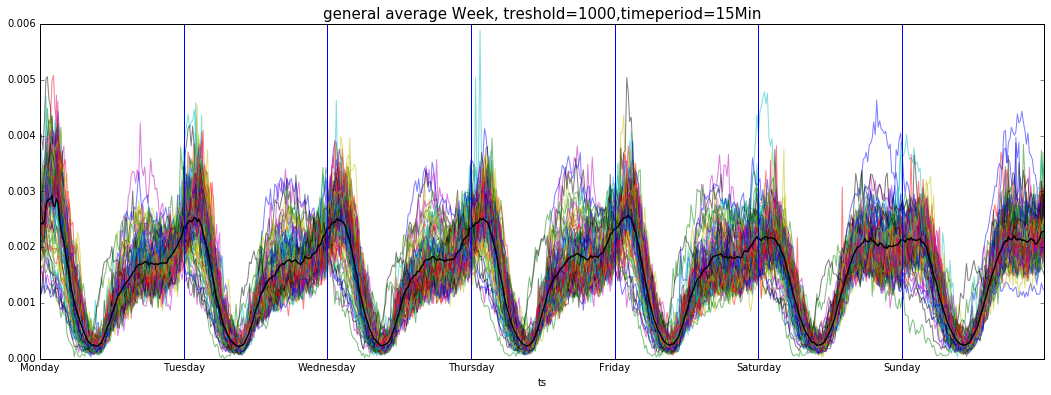

In [14]:
x = bulkWeeks(df, 'postalCode', title='general average Week', 
          av=True, th=1000, verbose=False, legend=False, tperiod='15Min')

Index([u'id', u'std'], dtype='object')


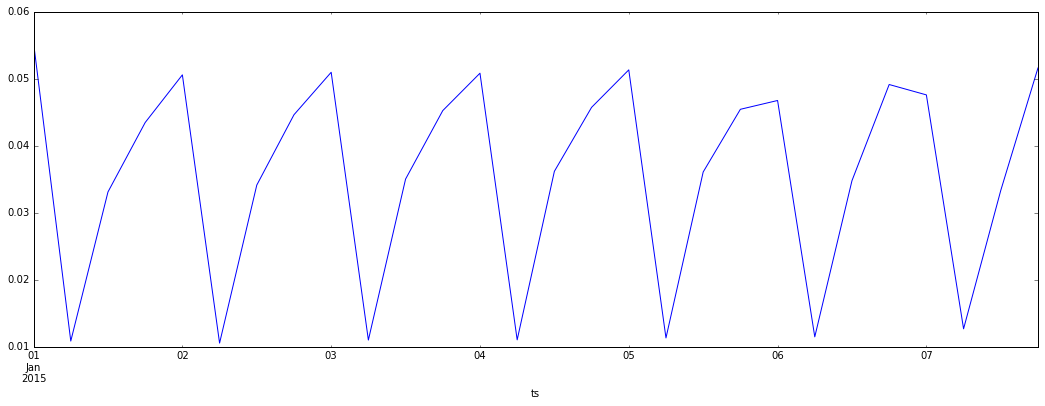

In [142]:
fig, ax = plt.subplots(figsize=(18,6))


m = df[['id', 'ts']].set_index('ts').resample('1D', how='count')
proper_dates = [x.date() for x in m.index[m['id']>0].tolist()]

x = averageWeek(df,ax=ax, tperiod='6h', treshold=0, verbose=False, mask=proper_dates)

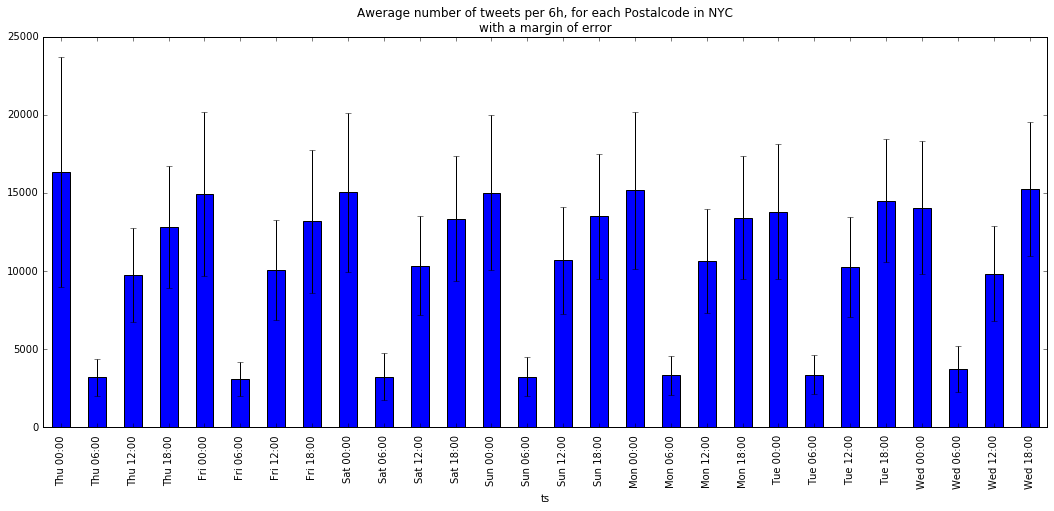

In [153]:
fig, ax = plt.subplots(figsize=(18,7))
# week = x.T
x['id'].plot(kind='bar', ax=ax, yerr=x['std'])
ax.set_ylim(0);
ax.set_xticklabels(x.index.strftime('%a %H:%M '),minor=False)
ax.set_title('Awerage number of tweets per 6h, for each Postalcode in NYC\nwith a margin of error');

## SnowStorm

In [154]:
def get_storm_week(df):
    '''get tweets from storm week only'''
    d1 = datetime.datetime(year=2015, month=1, day=25)
    d2 = d1 + datetime.timedelta(days = 7)
    
    return df[(df.ts >= d1)&(df.ts < d2)]

In [155]:
storm = get_storm_week(df)
storm.shape[0]

262379

Index([u'id', u'std'], dtype='object')


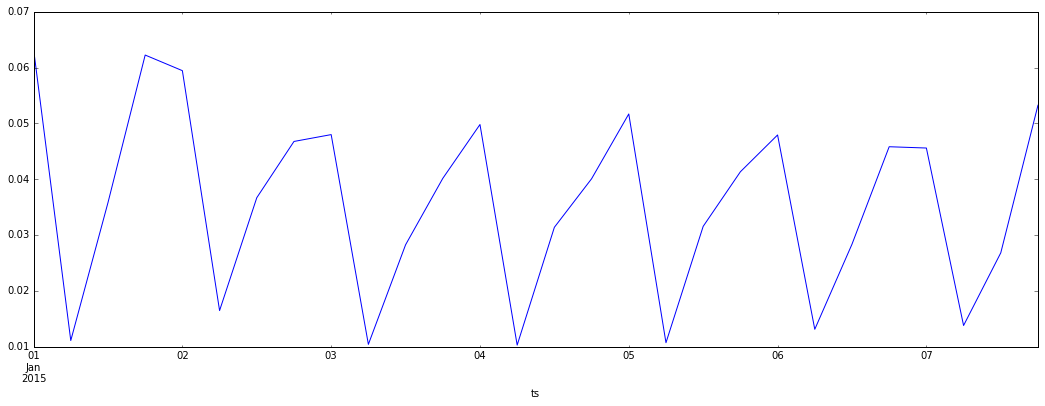

In [156]:
fig, ax = plt.subplots(figsize=(18,6))

st12h = averageWeek(storm,ax=ax, tperiod='6h', treshold=0, verbose=False, mask=proper_dates)

In [157]:
def divideBySum(df, axis=0):
    
    df2 = df.copy()
#     print df2['id']/df['id']
    df2['id'] = df2['id']/df2['id'].sum()
    df2['std'] = df2['std'] * (df2['id']/df['id'])
    return df2

In [158]:
xN, st12hN = (divideBySum(d) for d in (x, st12h) )

In [159]:
xN['storm'] = st12hN['id']

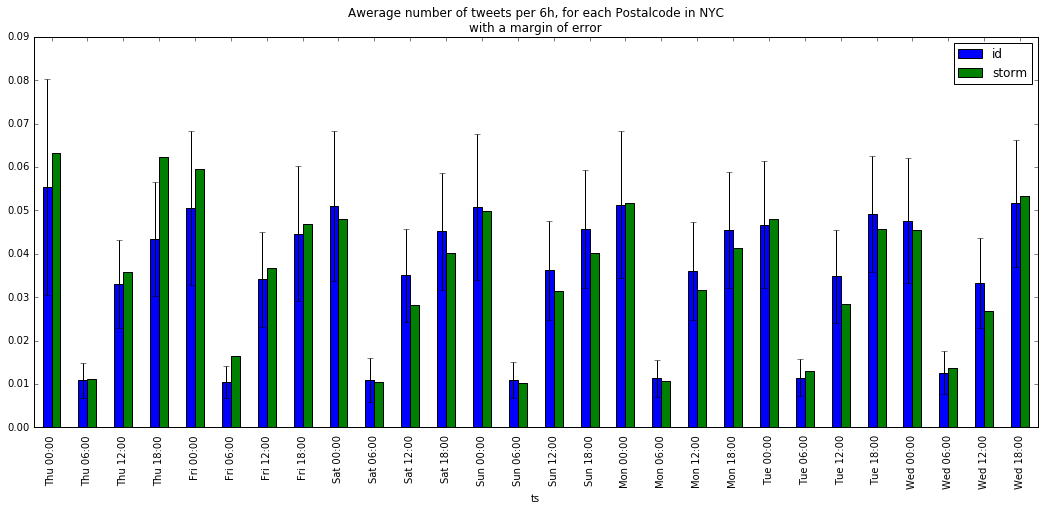

In [172]:
fig, ax = plt.subplots(figsize=(18,7))
xN[['id','storm']].plot(kind='bar', ax=ax, yerr=(xN['std'], [0]*len(xN)))

ax.set_ylim(0);
ax.set_xticklabels(x.index.strftime('%a %H:%M '),minor=False)
# ax.set_xticklabels(x.index.strftime('%a %H:%M '),minor=False)
ax.set_title('Awerage number of tweets per 6h, for each Postalcode in NYC\nwith a margin of error');

## Lower Manhattan

Index([u'id', u'std'], dtype='object')
Index([u'id', u'std'], dtype='object')


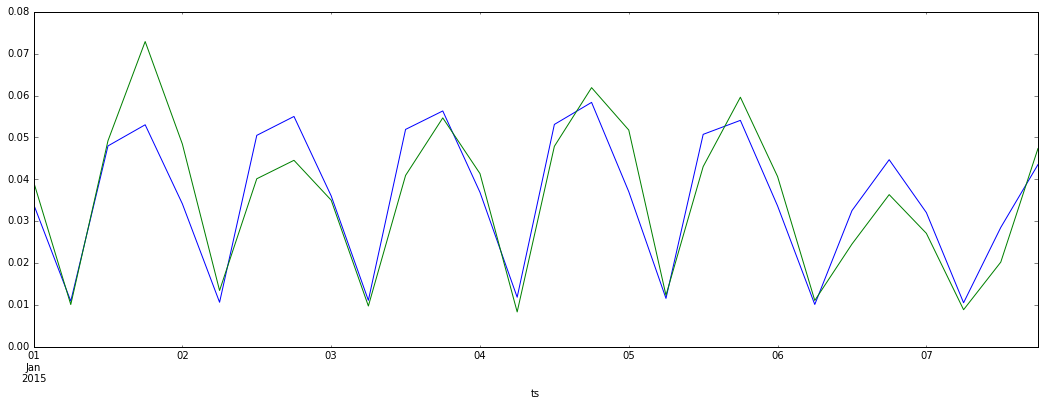

In [185]:
lm = (10038, 10004, 10280, 10007, 10013) # DownTown

fig, ax = plt.subplots(figsize=(18,6))
x1 = averageWeek(df[df.postalCode.isin(lm)],ax, tperiod='6h', label='id'  )
x2 = averageWeek(storm[storm.postalCode.isin(lm)],ax, tperiod='6h', label='id')

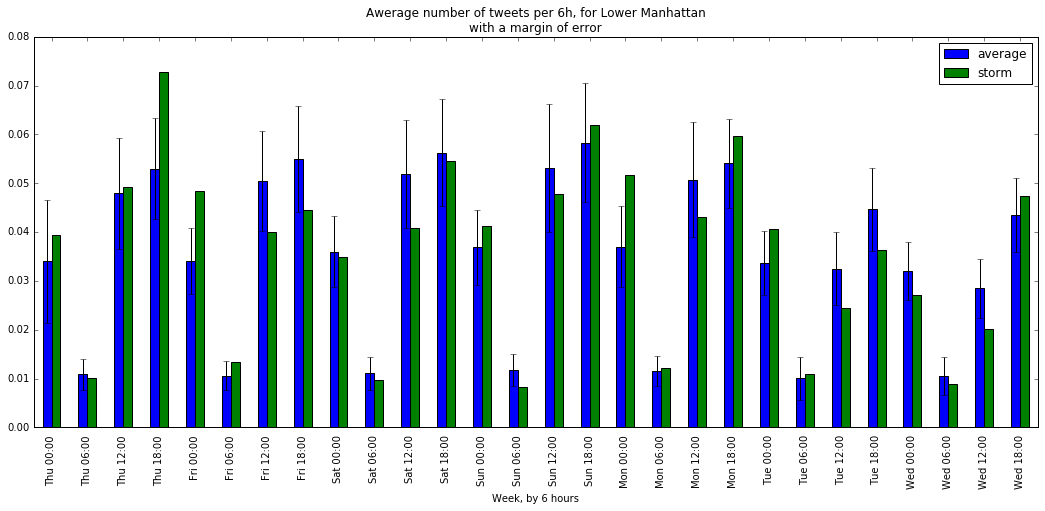

In [186]:
xN, st12hN = (divideBySum(d) for d in (x1, x2) )
xN.columns = ['average','std']
xN['storm'] = st12hN['id']
fig, ax = plt.subplots(figsize=(18,7))
xN[['average','storm']].plot(kind='bar', ax=ax, yerr=(xN['std'], [0]*len(xN)))

ax.set_ylim(0);
ax.set_xticklabels(x.index.strftime('%a %H:%M '),minor=False)
ax.set_title('Awerage number of tweets per 6h, for Lower Manhattan\nwith a margin of error');
ax.set_xlabel('Week, by 6 hours')

## Flatbush

Index([u'id', u'std'], dtype='object')
Index([u'id', u'std'], dtype='object')


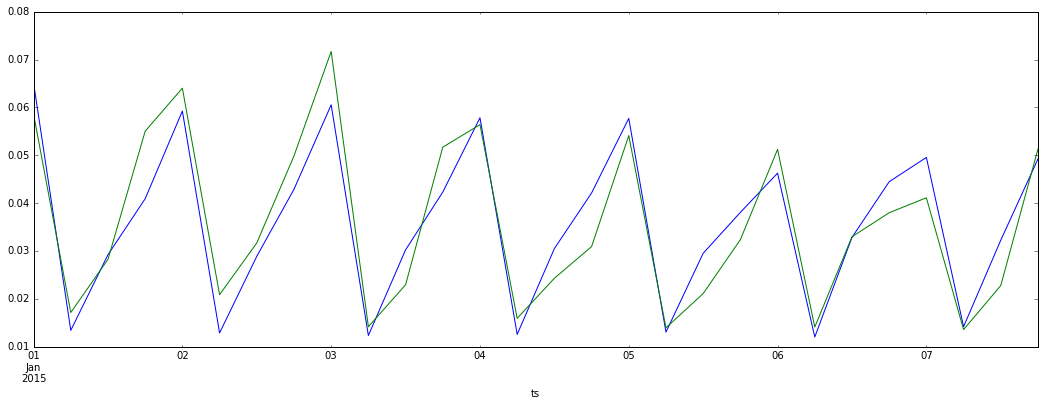

In [187]:
fb = (11204, 11240, 11223, 11229, 11210, 11235, 11224, 11214, 11228, 11209, 11220, 11219) ## flatbysg

fig, ax = plt.subplots(figsize=(18,6))
x1 = averageWeek(df[df.postalCode.isin(fb)],ax, tperiod='6h', label='id'  )
x2 = averageWeek(storm[storm.postalCode.isin(fb)],ax, tperiod='6h', label='id')

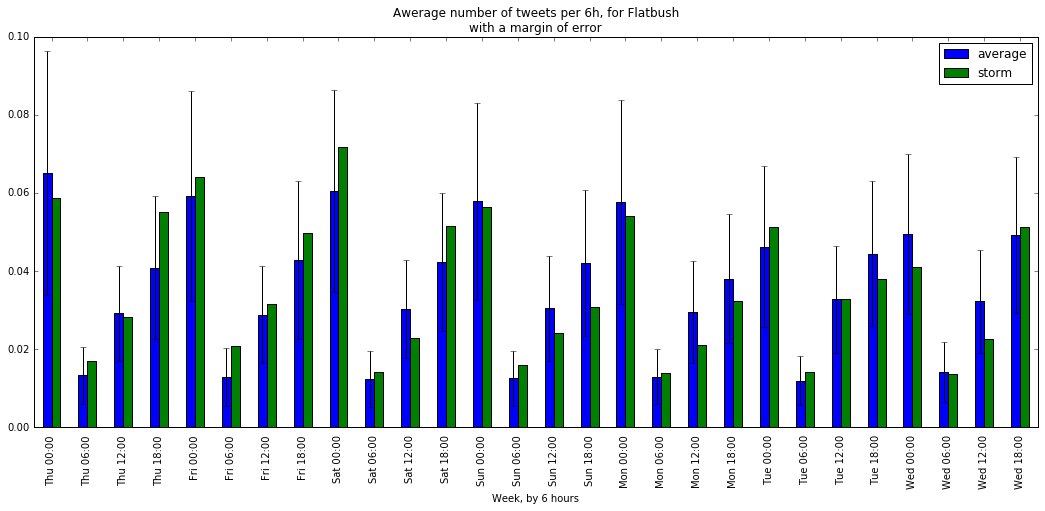

In [188]:
xN, st12hN = (divideBySum(d) for d in (x1, x2) )
xN.columns = ['average','std']
xN['storm'] = st12hN['id']
fig, ax = plt.subplots(figsize=(18,7))
xN[['average','storm']].plot(kind='bar', ax=ax, yerr=(xN['std'], [0]*len(xN)))

ax.set_ylim(0);
ax.set_xticklabels(x.index.strftime('%a %H:%M '),minor=False)
ax.set_title('Awerage number of tweets per 6h, for Flatbush\nwith a margin of error');
ax.set_xlabel('Week, by 6 hours')

### Jackson Hights

Index([u'id', u'std'], dtype='object')
Index([u'id', u'std'], dtype='object')


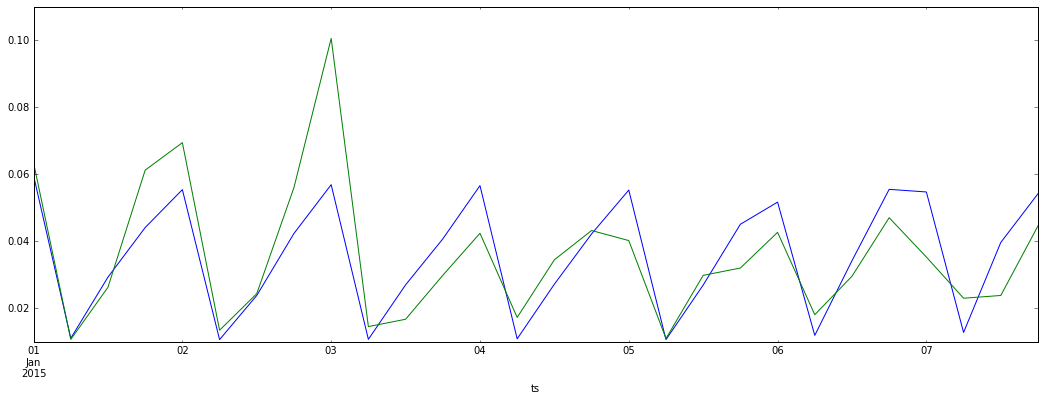

In [190]:
queens = (11373, 11372, 11368, 11373)

fig, ax = plt.subplots(figsize=(18,6))
x1 = averageWeek(df[df.postalCode.isin(queens)],ax, tperiod='6h', label='id'  )
x2 = averageWeek(storm[storm.postalCode.isin(queens)],ax, tperiod='6h', label='id')

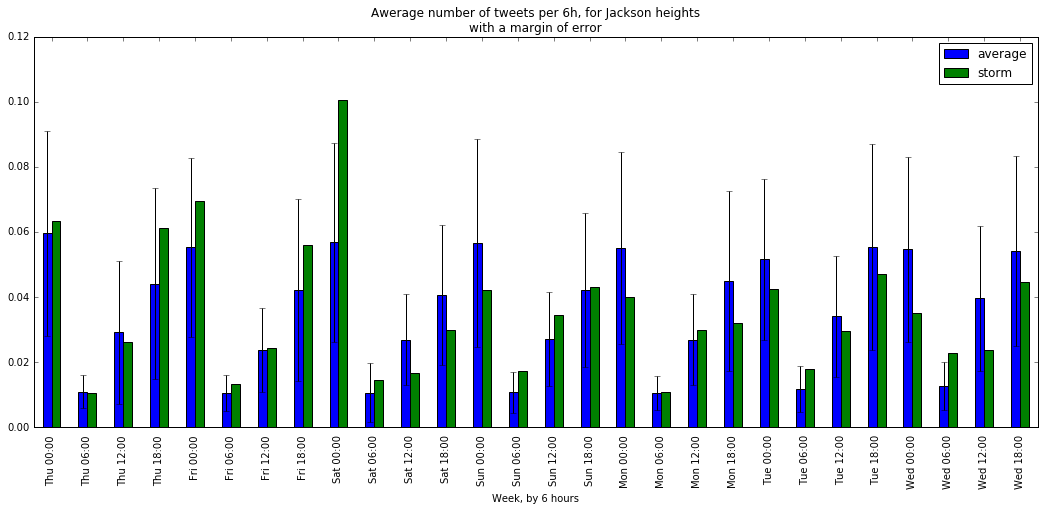

In [192]:
xN, st12hN = (divideBySum(d) for d in (x1, x2) )
xN.columns = ['average','std']
xN['storm'] = st12hN['id']
fig, ax = plt.subplots(figsize=(18,7))
xN[['average','storm']].plot(kind='bar', ax=ax, yerr=(xN['std'], [0]*len(xN)))

ax.set_ylim(0);
ax.set_xticklabels(x.index.strftime('%a %H:%M '),minor=False)
ax.set_title('Awerage number of tweets per 6h, for Jackson heights\nwith a margin of error');
ax.set_xlabel('Week, by 6 hours')

## Graphs

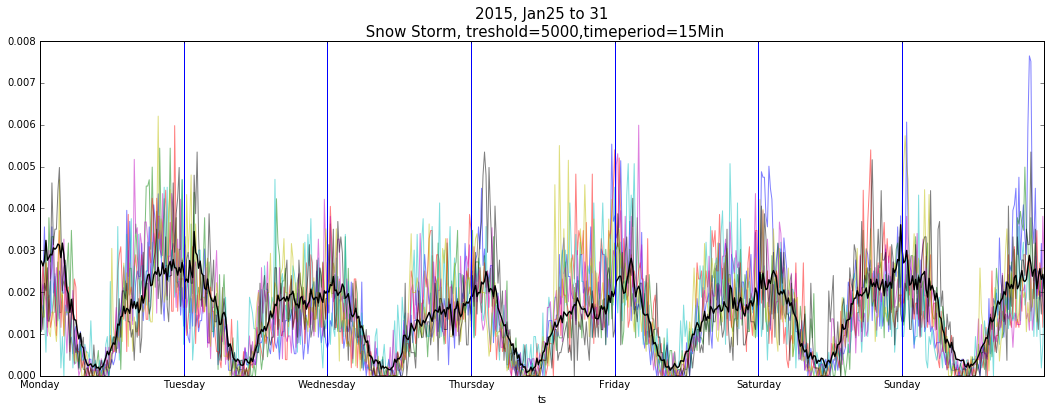

In [57]:
x = bulkWeeks(storm, 'postalCode', title='2015, Jan25 to 31\n Snow Storm', 
          av=True, th=5000, verbose=False, legend=False)

In [86]:
lm = (10038, 10004, 10280, 10007, 10013) # DownTown

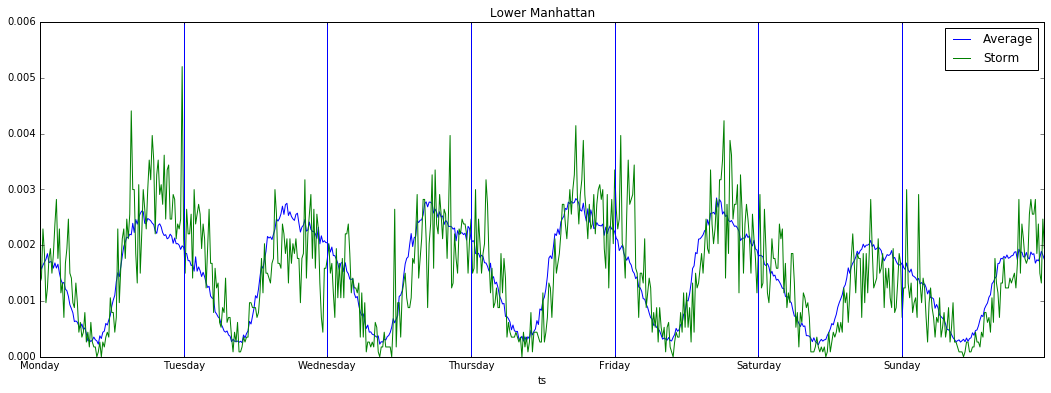

In [89]:

fig, ax = plt.subplots(figsize=(18,6))
x1 = averageWeek(df[df.postalCode.isin(lm)],ax, label='Average'  )
x2 = averageWeek(storm[storm.postalCode.isin(lm)],ax, label='Storm')

labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dates = [datetime.datetime(year=2015, month=1, day=i, hour=0, minute=0) for i in range(1,8)]

ax.set_xticklabels([],minor=False) # the default
ax.set_xticklabels(labels,minor=True)

for d in dates:
    ax.axvline(x=d, ymin=0, ymax=1)
    
plt.legend()
plt.title('Lower Manhattan')

In [ ]:
lm = (10038, 10004, 10280, 10007, 10013) # DownTown

In [ ]:

fig, ax = plt.subplots(figsize=(18,6))
x1 = averageWeek(df[df.postalCode.isin(lm)],ax, label='Average'  )
x2 = averageWeek(storm[storm.postalCode.isin(lm)],ax, label='Storm')

labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dates = [datetime.datetime(year=2015, month=1, day=i, hour=0, minute=0) for i in range(1,8)]

ax.set_xticklabels([],minor=False) # the default
ax.set_xticklabels(labels,minor=True)

for d in dates:
    ax.axvline(x=d, ymin=0, ymax=1)
    
plt.legend()
plt.title('Lower Manhattan')

In [92]:
fb = (11204, 11240, 11223, 11229, 11210, 11235, 11224, 11214, 11228, 11209, 11220, 11219)

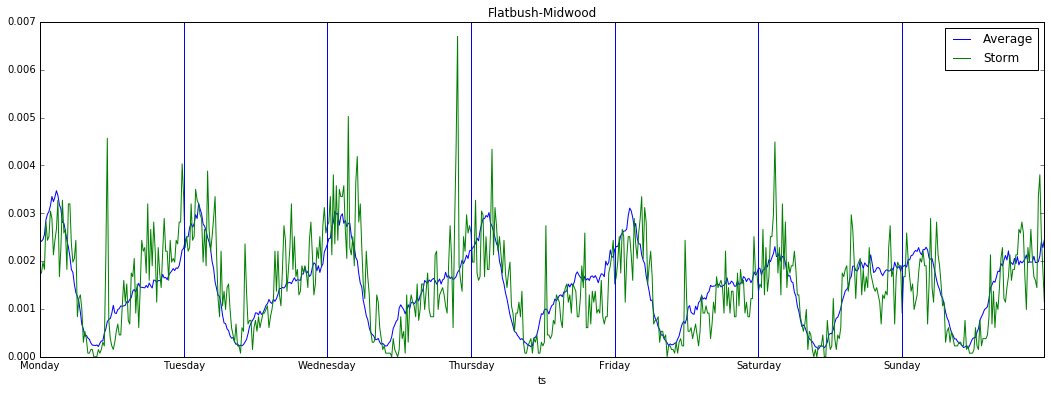

In [93]:

fig, ax = plt.subplots(figsize=(18,6))
x1 = averageWeek(df[df.postalCode.isin(fb)],ax, label='Average'  )
x2 = averageWeek(storm[storm.postalCode.isin(fb)],ax, label='Storm')

labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dates = [datetime.datetime(year=2015, month=1, day=i, hour=0, minute=0) for i in range(1,8)]

ax.set_xticklabels([],minor=False) # the default
ax.set_xticklabels(labels,minor=True)

for d in dates:
    ax.axvline(x=d, ymin=0, ymax=1)
    
plt.legend()
plt.title('Flatbush-Midwood')

In [96]:
queens = (11373, 11372, 11368, 11373)

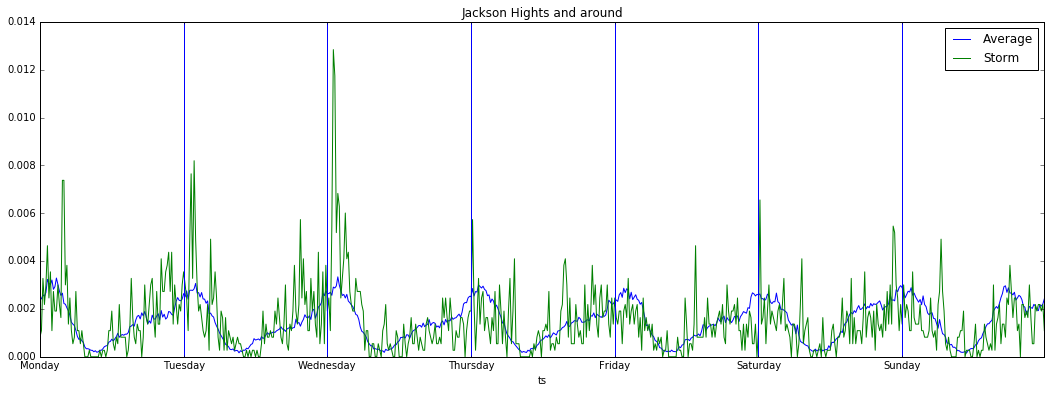

In [98]:

fig, ax = plt.subplots(figsize=(18,6))
x1 = averageWeek(df[df.postalCode.isin(queens)],ax, label='Average'  )
x2 = averageWeek(storm[storm.postalCode.isin(queens)],ax, label='Storm')

labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dates = [datetime.datetime(year=2015, month=1, day=i, hour=0, minute=0) for i in range(1,8)]

ax.set_xticklabels([],minor=False) # the default
ax.set_xticklabels(labels,minor=True)

for d in dates:
    ax.axvline(x=d, ymin=0, ymax=1)
    
plt.legend()
plt.title('Jackson Hights and around')

## Clustering

In [102]:
from scipy.cluster.vq import kmeans2
import Pycluster


In [99]:
def clusterAndPlot(df,k, height=10, engine='PyCluster', cmap='spectral'):
    '''calculate and plot kmean clustering'''
    fig, axes = plt.subplots(k+1, figsize=(18,height), sharex='all', sharey='all')
    
    if engine == 'scipy':
        centroids, label = kmeans2(df, k, iter=100, thresh=1e-05)
    else:
        labels, error, nfound = Pycluster.kcluster(df, k)
    df['label'] = labels
    
    
    colors = nColors(k=k, cmap=cmap)
        
    #one by one
    for l, g in df.groupby('label'):
        g.T.plot(ax=axes[l], legend=0, c=colors[l],alpha=.2)
        axes[l].set_title('cluster %d, %d zipcodes'% (l, len(g)))
        
        pd.Series(g.mean(0)).plot(ax=axes[-1], label='cluster %d'% (l ), c=colors[l])
        
    #     plt.legend()
    return df

In [101]:
def normaliseTimeseries(df, transpose=True):
    '''transpose and normilize timeseries by themself
       removing the median and dividing by sdt'''
    
    if transpose:
        df = df.T
    
    return (df - df.mean(0))/df.std(0)
    

In [105]:
def nColors(k=2, cmap='spectral'):
    '''
    manual colors retrieval from colormap
    '''
    from pylab import get_cmap

    if type(cmap) == str:
        cm = get_cmap(cmap)
        colors = [cm(1. * i / (k - 1)) for i in range(k)]
    elif cmap is None:
        colors = ['k']
    else:
        colors = cmap

    return colors

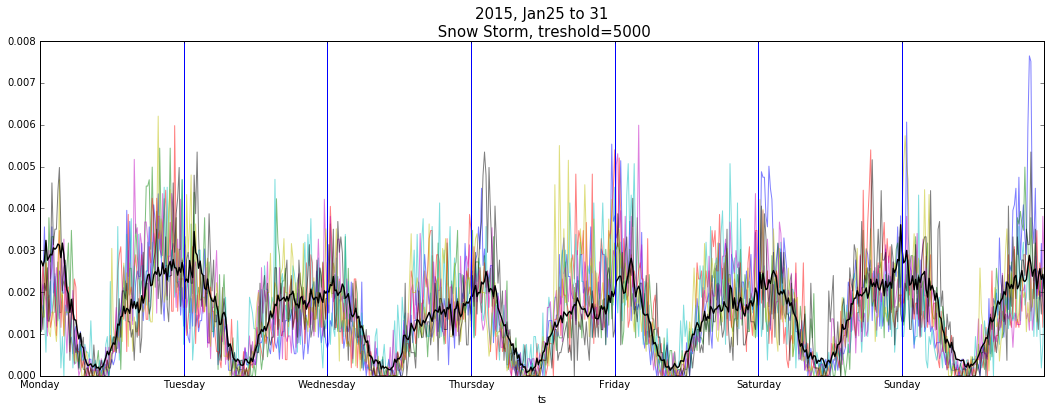

In [100]:
sw = bulkWeeks(storm, 'postalCode', title='2015, Jan25 to 31\n Snow Storm', 
          av=True, th=5000, verbose=False, legend=False)

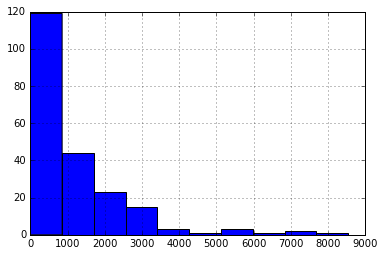

In [172]:
sw.sum().hist()

In [173]:
sw1000 = sw.T[sw.sum()>1000].T

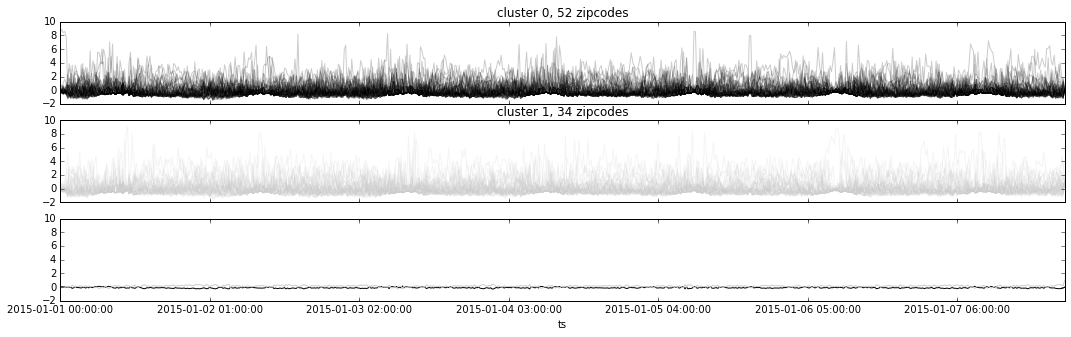

In [174]:
dfLabels = clusterAndPlot(normaliseTimeseries(sw1000) , 2, height=5)

In [16]:
import geopandas as gp
zipPath = '../../data/misk/nyc-zip-code-tabulation-areas-polygons.geojson'
zips = gp.read_file(zipPath)[['geometry', 'postalCode']]
zips['postalCode']  = zips['postalCode'].astype(int)
print zips.crs

{'init': u'epsg:4326'}


In [176]:
labels = dfLabels.reset_index()[['index','label']].rename(columns={'index':'postalCode'})
labels.head(4)


ts,postalCode,label
0,83,1
1,10001,0
2,10002,1
3,10003,1


In [177]:
labelZip = zips.merge(labels, how='left', on='postalCode')

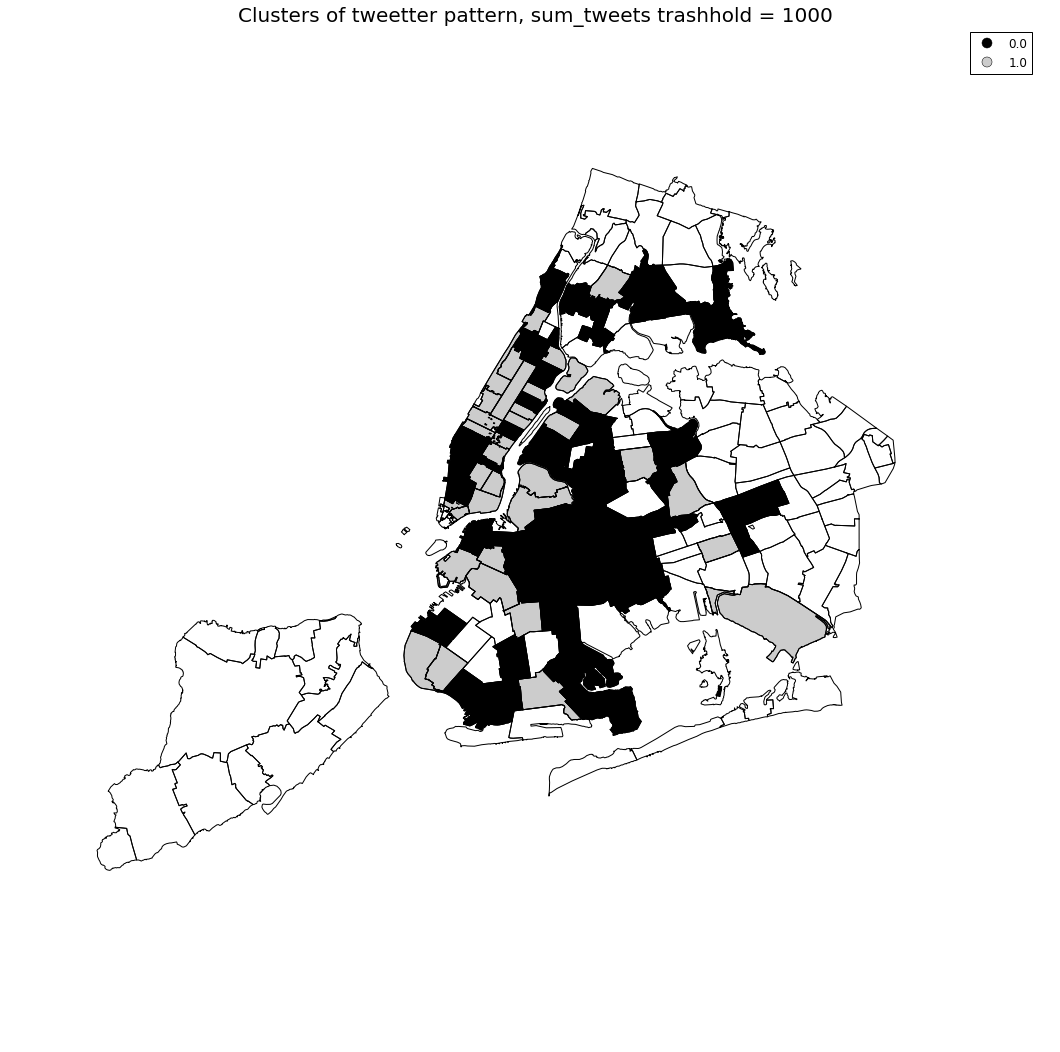

In [178]:
fig, ax = plt.subplots(figsize=(18,18))


labelZip.plot(alpha=0, ax=ax) # empty back
labelZip[pd.notnull(labelZip.label)].plot(column='label', categorical=1,
           colormap='spectral', ax=ax,
           alpha=1, legend=True)

plt.title('Clusters of tweetter pattern, sum_tweets trashhold = 1000', fontsize=20)
plt.axis('off');

In [147]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

In [203]:
X = normaliseTimeseries(sw1000).dropna()
A = AffinityPropagation(damping=0.5, max_iter=200, convergence_iter=15)

In [205]:
af = A.fit(X)

cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters_ = len(cluster_centers_indices)

In [206]:
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

Estimated number of clusters: 17
Silhouette Coefficient: 0.252


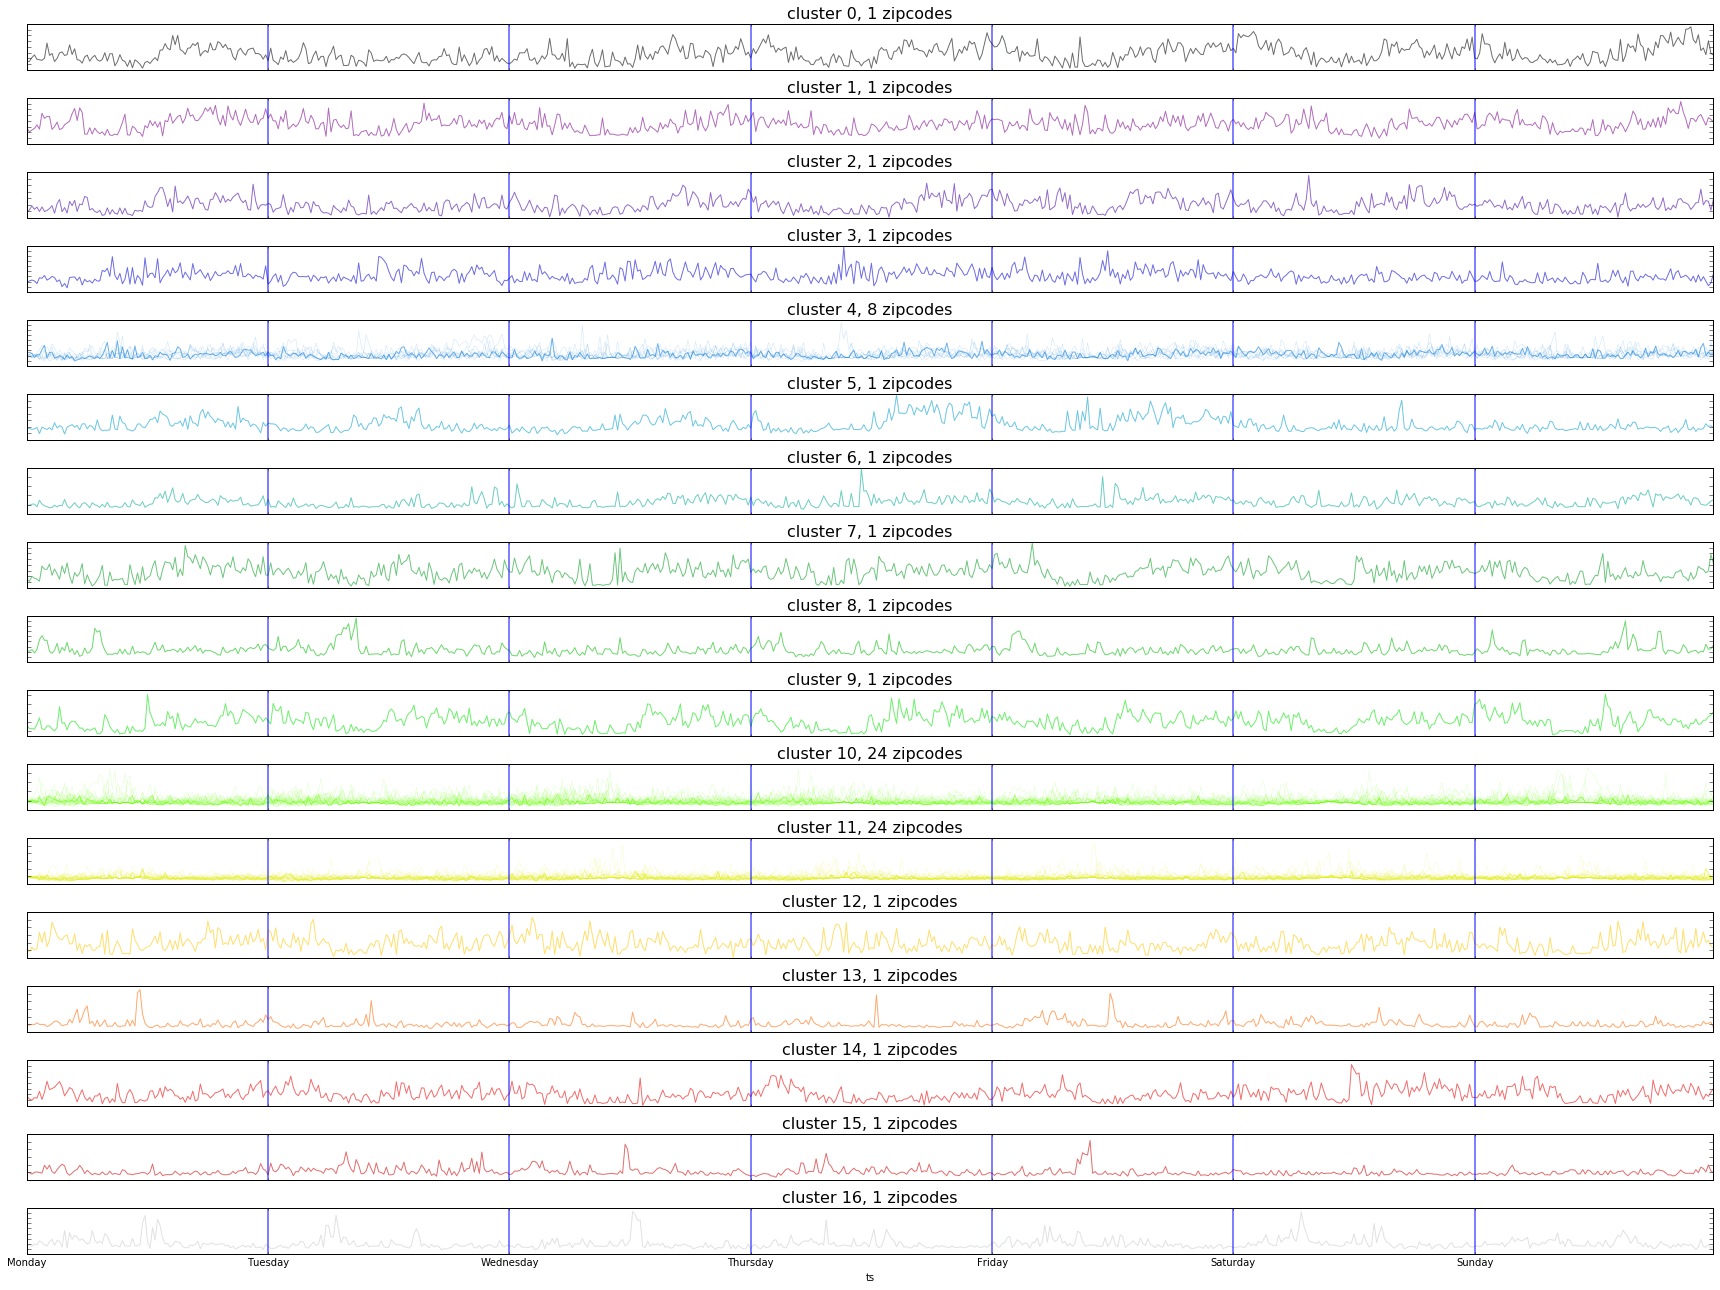

In [207]:
fig, axes = plt.subplots(n_clusters_, figsize=(24,18), sharex='all')

colors = nColors(k=n_clusters_, cmap='spectral')
ticks = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dates = [datetime.datetime(year=2015, month=1, day=i, hour=0, minute=0) for i in range(1,8)]

    

for k, col in zip(range(n_clusters_), colors):    
    X.iloc[cluster_centers_indices[k],:].plot(lw=1, c=col, label=k, alpha=.5, ax=axes[k])
    X[labels==k].T.plot(lw=.5, c=col,alpha=0.2, ax=axes[k], legend=0)
    axes[k].set_title('cluster %d, %d zipcodes' % (k, len(X[labels==k])), fontsize=16)
    
    axes[k].set_xticklabels([],minor=False) # the default
    axes[k].set_xticklabels(ticks,minor=True)
    axes[k].set_yticklabels([],minor=False) 
    
    for d in dates:
        axes[k].axvline(x=d, ymin=0, ymax=1, alpha=.5, linewidth=2)



    
plt.tight_layout()

In [215]:
result = sw1000.T.dropna()
result['label'] = labels
result.reset_index(inplace=1)
result.rename(columns={'index':'postalCode'},inplace=1)

# result.head(2)
r = result[['postalCode','label']]

In [216]:
labelZip = zips.merge(r, how='left', on='postalCode')

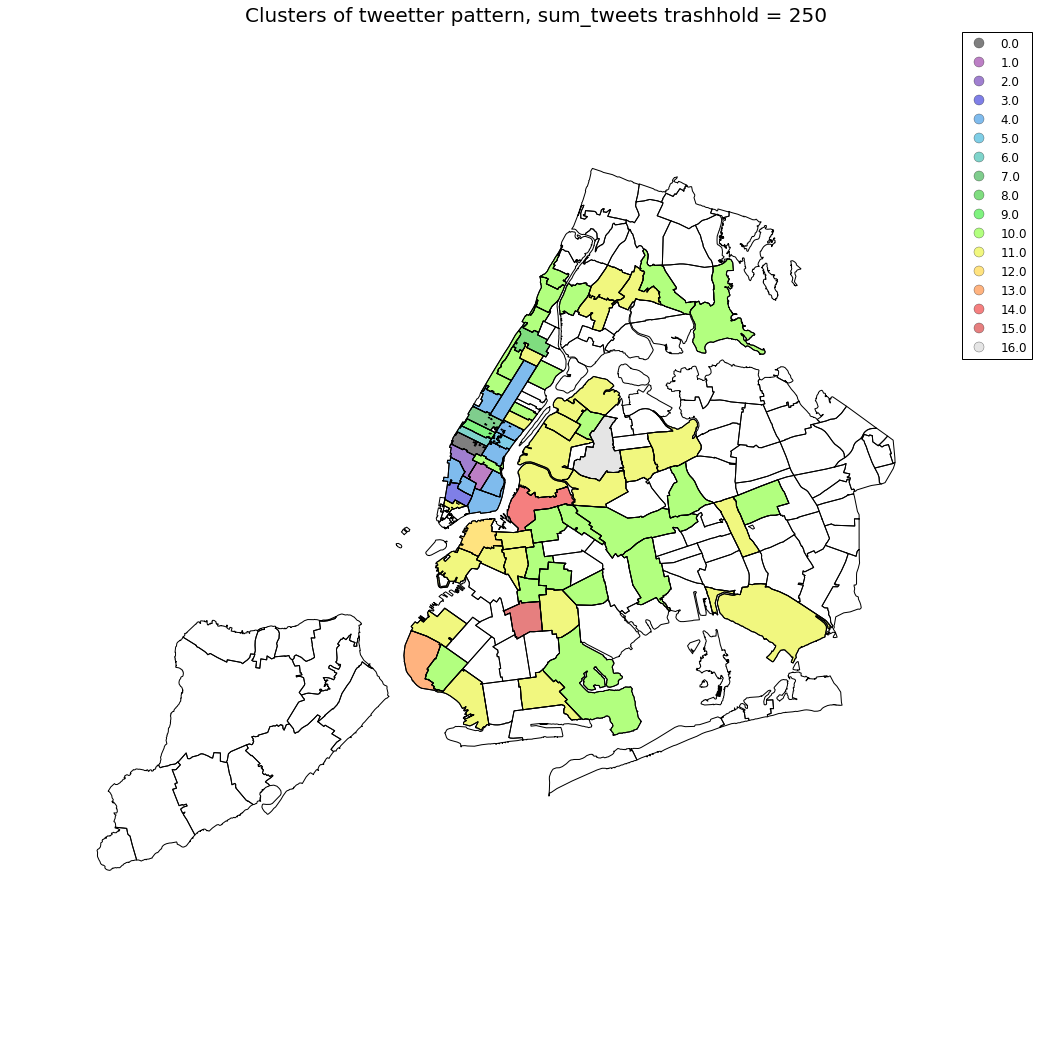

In [217]:
fig, ax = plt.subplots(figsize=(18,18))

labelZip.plot(alpha=0, ax=ax) # empty back
labelZip[pd.notnull(labelZip.label)].plot(column='label', categorical=1,
                                          colormap='spectral', ax=ax,
                                          alpha=.5, legend=True)

plt.title('Clusters of tweetter pattern, sum_tweets trashhold = 250', fontsize=20)
plt.axis('off');

In [27]:
def plotDencity(df, zips=zips, ax=None):
    total_ = df.shape[0]
    
    d = df.groupby('postalCode').agg({'id':sum}).reset_index()
    d['id'] = d['id'].apply(lambda x: 100.0*x/total_)
    
    zd = zips.merge(d, how='left', on='postalCode')
    
    if not ax:
        fig, ax = plt.subplots(figsize=(12,12))
        
    zd.plot(alpha=0, ax=ax) # empty back
    zd[pd.notnull(zd['id'])].plot(column='id', colormap='Reds', ax=ax, alpha=.5)
    plt.axis('off');
    

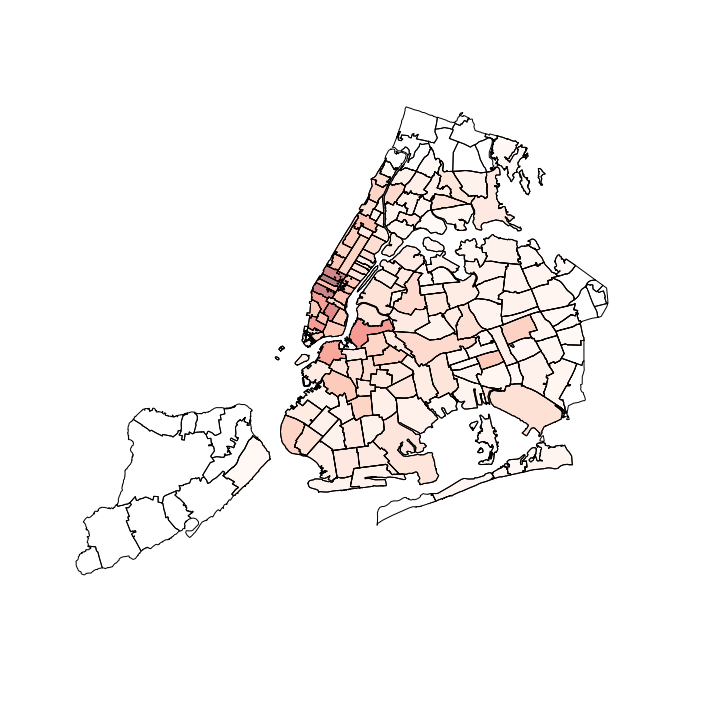

In [28]:
plotDencity(storm)

In [ ]:
plotDencity(df)

In [18]:
sp = storm.groupby('postalCode').agg({'id':sum}).reset_index()
sp['id'] = sp['id'].apply(lambda x)
storm = zips.merge(sp, how='left', on='postalCode')

In [23]:
all = df.groupby('postalCode').agg({'id':sum}).reset_index()
all = zips.merge(sp, how='left', on='postalCode')

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9,9))

plotDencity(df, ax=axes[0])
plotDencity(storm, ax=axes[1])